<a href="https://colab.research.google.com/github/rakeshgovindsuresh/Python-Practice/blob/main/CNNWIth%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
346/346 [==============================] - 2s 3ms/step - loss: 9.1325e-05 - val_loss: 8.9701e-05
Epoch 2/50
346/346 [==============================] - 1s 3ms/step - loss: 7.9067e-05 - val_loss: 9.3079e-05
Epoch 3/50
346/346 [==============================] - 1s 3ms/step - loss: 7.5134e-05 - val_loss: 9.2530e-05
Epoch 4/50
346/346 [==============================] - 1s 3ms/step - loss: 7.4663e-05 - val_loss: 8.9207e-05
Epoch 5/50
346/346 [==============================] - 1s 3ms/step - loss: 7.2897e-05 - val_loss: 9.3769e-05
Epoch 6/50
346/346 [==============================] - 1s 4ms/step - loss: 7.2184e-05 - val_loss: 9.3501e-05
Epoch 7/50
346/346 [==============================] - 2s 5ms/step - loss: 7.2056e-05 - val_loss: 8.9534e-05
Epoch 8/50
346/346 [==============================] - 1s 4ms/step - loss: 7.4149e-05 - val_loss: 1.0370e-04
Epoch 9/50
346/346 [==============================] - 1s 3ms/step - loss: 7.4451e-05 - val_loss: 9.4528e-05
Epoch 10/50
346/346 [=======

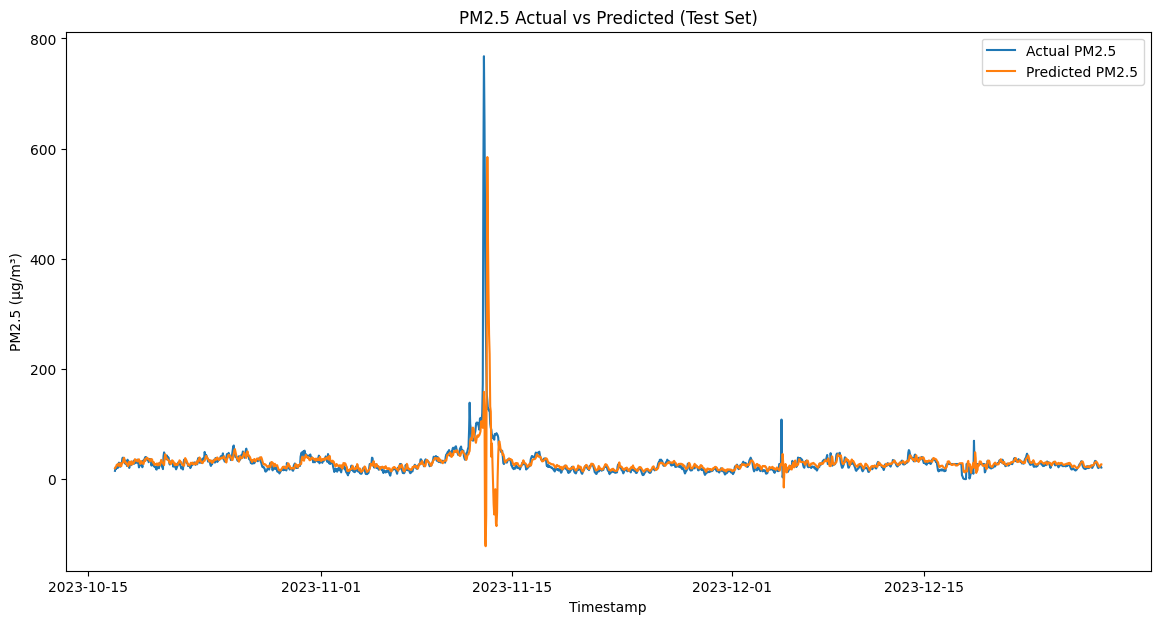

1/1 [==============================] - 0s 28ms/step


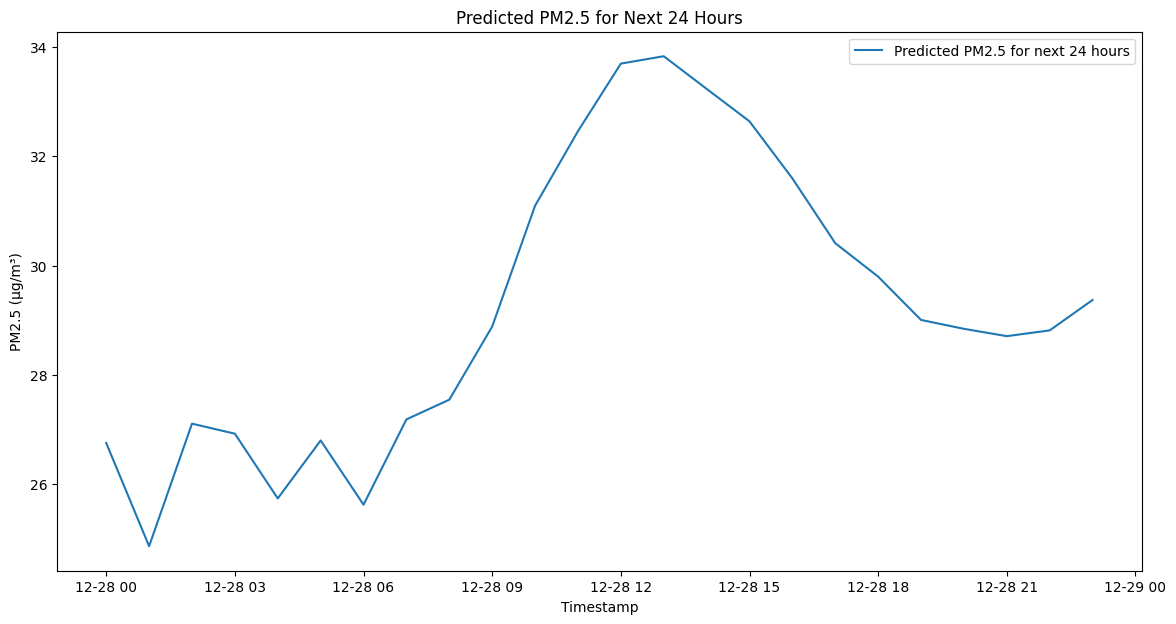

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load the dataset
file_path = '/content/Raw_data_1Hr_2023_site_288_Velachery_Res._Area_Chennai_CPCB_1Hr (1).csv'
data = pd.read_csv(file_path)

# Parse the timestamp and set it as index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], dayfirst=True)
data.set_index('Timestamp', inplace=True)

# Impute missing values with mean for numerical columns

data.fillna(data.mean(), inplace=True)

# Drop columns with no records if necessary

data.dropna(axis=1, how='all', inplace=True)

# Drop rows with NaN values in the target or features

data.dropna(subset=['RH (%)', 'WS (m/s)', 'WD (deg)', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)'], inplace=True)
# Select the PM2.5 column for prediction
pm25_values = data[['PM2.5 (µg/m³)']].values

# Normalize the data
scaler = MinMaxScaler()
pm25_scaled = scaler.fit_transform(pm25_values)

# Create sequences for CNN
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 24  # Using 24 hours (1 day) as the sequence length
X, y = create_sequences(pm25_scaled, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for the CNN input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
test_mae = mean_absolute_error(y_test_actual, test_predictions)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')

# Plot the actual and predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(data.index[seq_length + train_size:], y_test_actual, label='Actual PM2.5')
plt.plot(data.index[seq_length + train_size:], test_predictions, label='Predicted PM2.5')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('PM2.5 Actual vs Predicted (Test Set)')
plt.legend()
plt.show()

# Predict the next 24 hours
last_sequence = pm25_scaled[-seq_length:]
next_predictions = []

for i in range(24):
    pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    next_predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the next day predictions
next_predictions = scaler.inverse_transform(np.array(next_predictions).reshape(-1, 1))

# Create a new dataframe to hold the next day predictions
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
future_df = pd.DataFrame(next_predictions, index=future_dates, columns=['Predicted PM2.5'])

# Plot the predictions for the next 24 hours
plt.figure(figsize=(14, 7))
plt.plot(future_df.index, future_df['Predicted PM2.5'], label='Predicted PM2.5 for next 24 hours')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Predicted PM2.5 for Next 24 Hours')
plt.legend()
plt.show()
